In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
from IPython.display import display
import os
plt.style.use("seaborn")
%matplotlib inline  

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
#from xgboost import XGBClassifier
#from lightgbm import LGBMRegressor


#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [3]:
test_df = pd.read_csv('IEEE_test_data.csv')
df = pd.read_csv('IEEE_train_data.csv')

In [4]:
test_df.head()

,id,timestamp,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,turbine_id
0,0,4/5/2021 5:36,715.395435,727.824636,16.424948,NaN,57.012666,705.473653,32.653601,29.903539,114.583717,151.190527,220.806147,7.178372,0.518546,Turbine_123
1,1,1/22/2021 18:08,464.797602,477.312037,16.800411,966.249512,42.624767,112.306211,36.228663,33.264307,96.622513,118.003382,262.500356,6.120114,0.655806,Turbine_19
2,2,2/12/2021 23:35,124.409334,116.650399,13.072779,NaN,60.494156,160.127332,33.011556,32.325333,83.454244,98.143848,34.148368,3.910857,0.253755,Turbine_18
3,3,4/20/2021 15:34,328.236440,325.810171,36.818389,854.034149,60.434220,199.202449,36.335106,34.576919,94.008233,105.963958,275.710378,5.411589,0.976659,Turbine_97
4,4,10/27/2021 2:19,436.704926,435.343811,27.606645,938.269928,55.116486,408.465846,33.643038,32.837904,99.589046,113.876025,62.810726,6.096257,0.374731,Turbine_120


In [5]:
df.columns

Index(['id', 'timestamp', 'active_power_calculated_by_converter',
       'active_power_raw', 'ambient_temperature', 'generator_speed',
       'generator_winding_temp_max', 'grid_power10min_average',
       'nc1_inside_temp', 'nacelle_temp',
       'reactice_power_calculated_by_converter', 'reactive_power',
       'wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence',
       'turbine_id', 'Target'],
      dtype='object')

In [6]:
df.shape

(591239, 17)

In [7]:
missing = df.isnull().sum()
missing = missing[missing > 0]
missing = missing.sort_values(ascending = False)
missing

generator_speed                           316836
ambient_temperature                         9797
nc1_inside_temp                              232
nacelle_temp                                 218
grid_power10min_average                       35
active_power_raw                              17
wind_speed_turbulence                         15
active_power_calculated_by_converter          10
wind_direction_raw                             7
reactice_power_calculated_by_converter         4
turbine_id                                     4
reactive_power                                 2
generator_winding_temp_max                     1
wind_speed_raw                                 1
dtype: int64

In [8]:
#filling the missing values 
df["turbine_id"].fillna(df["turbine_id"].mode()[0],inplace = True)
df.drop(["id","generator_speed"],axis=1,inplace=True)

In [9]:
df["timestamp"] = df['timestamp'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True);
df['timestamp'] = df['timestamp'].apply(lambda x: x.split(" ")[0]) 
df['timestamp']

0          6/22/2021
1          11/6/2021
2         12/23/2021
3           1/2/2021
4          12/6/2021
             ...    
591234     3/18/2021
591235     7/24/2021
591236     11/9/2021
591237      2/2/2021
591238      8/2/2021
Name: timestamp, Length: 591239, dtype: object

In [10]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df["Month"]=df["timestamp"].dt.month
df["quarter"]=df["timestamp"].dt.quarter
df.drop(["timestamp"],axis=1,inplace=True)

In [11]:
np.round(df.isnull().sum()*100.00/len(df),2).sort_values(ascending = False)


ambient_temperature                       1.66
nc1_inside_temp                           0.04
nacelle_temp                              0.04
grid_power10min_average                   0.01
active_power_calculated_by_converter      0.00
active_power_raw                          0.00
generator_winding_temp_max                0.00
reactice_power_calculated_by_converter    0.00
reactive_power                            0.00
wind_direction_raw                        0.00
wind_speed_raw                            0.00
wind_speed_turbulence                     0.00
turbine_id                                0.00
Target                                    0.00
Month                                     0.00
quarter                                   0.00
dtype: float64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591239 entries, 0 to 591238
Data columns (total 16 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   active_power_calculated_by_converter    591229 non-null  float64
 1   active_power_raw                        591222 non-null  float64
 2   ambient_temperature                     581442 non-null  float64
 3   generator_winding_temp_max              591238 non-null  float64
 4   grid_power10min_average                 591204 non-null  float64
 5   nc1_inside_temp                         591007 non-null  float64
 6   nacelle_temp                            591021 non-null  float64
 7   reactice_power_calculated_by_converter  591235 non-null  float64
 8   reactive_power                          591237 non-null  float64
 9   wind_direction_raw                      591232 non-null  float64
 10  wind_speed_raw                          5912

In [13]:
df["Target"].unique()

array([48.67090607, 47.77903175, 45.54294586, ..., 49.31467438,
       51.65279198, 45.78885269])

<AxesSubplot:>

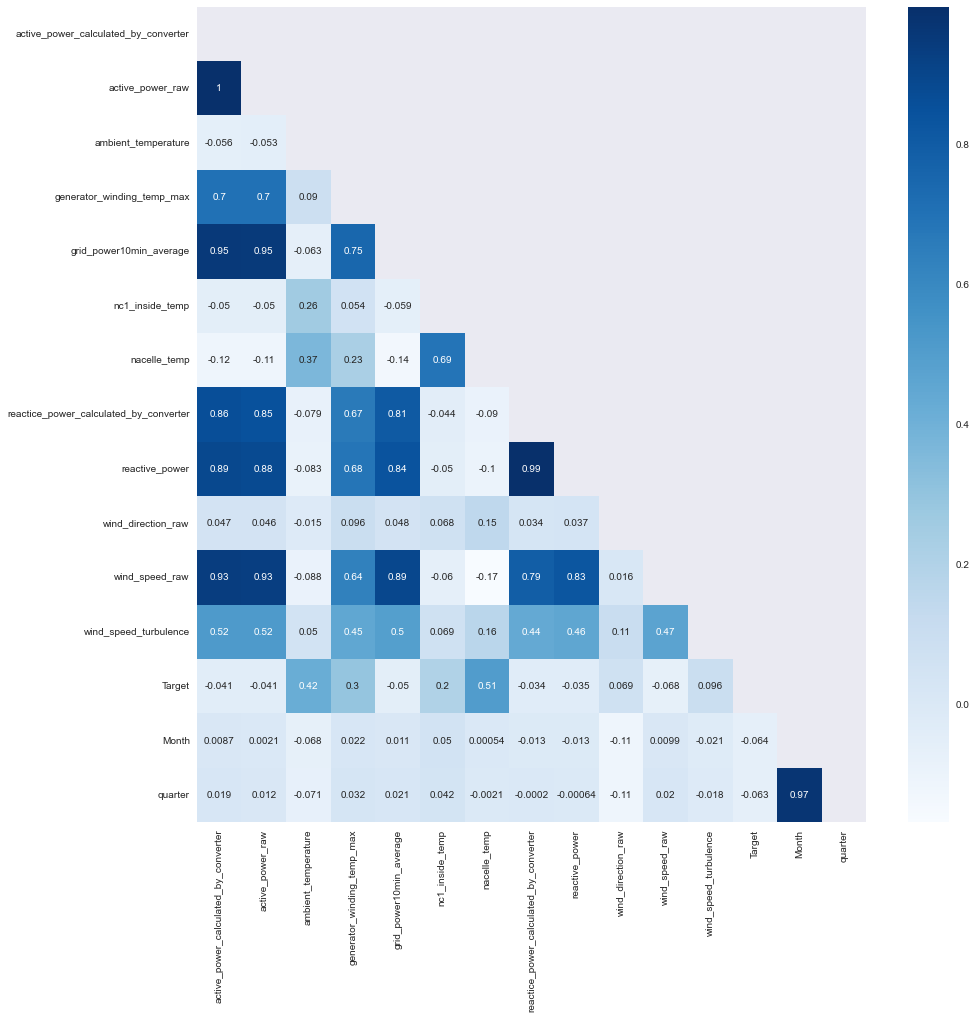

In [14]:
plt.figure(figsize=(15, 15))
corr_mask = np.triu(df.corr())
h_map = sns.heatmap(df.corr(), mask=corr_mask, cmap='Blues',annot=True)
h_map

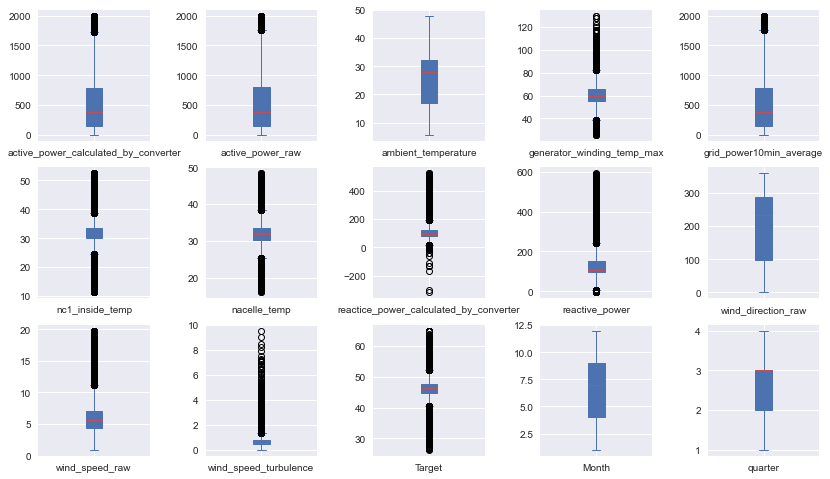

In [15]:
numeric_data=df.select_dtypes(exclude=["category"])
numeric_data.plot(subplots =True, kind = 'box', layout = (5,5), figsize = (14,14),patch_artist=True)
plt.subplots_adjust(wspace = 0.5)

In [16]:
import numpy as np
missing = df.isnull().sum()
missing = missing[missing > 0]
missing = missing.sort_values(ascending = False)
missing

ambient_temperature                       9797
nc1_inside_temp                            232
nacelle_temp                               218
grid_power10min_average                     35
active_power_raw                            17
wind_speed_turbulence                       15
active_power_calculated_by_converter        10
wind_direction_raw                           7
reactice_power_calculated_by_converter       4
reactive_power                               2
generator_winding_temp_max                   1
wind_speed_raw                               1
dtype: int64

In [17]:

columns=["ambient_temperature","reactive_power","active_power_raw","wind_speed_raw","generator_winding_temp_max","active_power_calculated_by_converter","reactice_power_calculated_by_converter",
         "wind_direction_raw","wind_speed_turbulence","grid_power10min_average","nacelle_temp","nc1_inside_temp","ambient_temperature"]
for n in columns:
    data = df[n][~df[n].isna()]
    df[n] = df[n].fillna(np.percentile(data,50))
    

In [18]:
missing = df.isnull().sum()
missing

active_power_calculated_by_converter      0
active_power_raw                          0
ambient_temperature                       0
generator_winding_temp_max                0
grid_power10min_average                   0
nc1_inside_temp                           0
nacelle_temp                              0
reactice_power_calculated_by_converter    0
reactive_power                            0
wind_direction_raw                        0
wind_speed_raw                            0
wind_speed_turbulence                     0
turbine_id                                0
Target                                    0
Month                                     0
quarter                                   0
dtype: int64

In [19]:
df["turbine_id"].unique()

array(['Turbine_01', 'Turbine_97', 'Turbine_158', 'Turbine_20',
       'Turbine_120', 'Turbine_14', 'Turbine_15', 'Turbine_105',
       'Turbine_139', 'Turbine_19', 'Turbine_108', 'Turbine_10',
       'Turbine_18', 'Turbine_13', 'Turbine_103', 'Turbine_123'],
      dtype=object)

In [20]:
df.shape

(591239, 16)

In [21]:
le = LabelEncoder()
df['turbine_id']=le.fit_transform(df['turbine_id'])

In [22]:
df.columns

Index(['active_power_calculated_by_converter', 'active_power_raw',
       'ambient_temperature', 'generator_winding_temp_max',
       'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp',
       'reactice_power_calculated_by_converter', 'reactive_power',
       'wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence',
       'turbine_id', 'Target', 'Month', 'quarter'],
      dtype='object')

In [23]:
df.dtypes

active_power_calculated_by_converter      float64
active_power_raw                          float64
ambient_temperature                       float64
generator_winding_temp_max                float64
grid_power10min_average                   float64
nc1_inside_temp                           float64
nacelle_temp                              float64
reactice_power_calculated_by_converter    float64
reactive_power                            float64
wind_direction_raw                        float64
wind_speed_raw                            float64
wind_speed_turbulence                     float64
turbine_id                                  int32
Target                                    float64
Month                                       int64
quarter                                     int64
dtype: object

In [24]:
x = df.drop(columns="Target")           
y = df["Target"]   

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV

In [26]:
# Scale data before applying PCA
scaling=StandardScaler()
 
# Use fit and transform method
scaling.fit(x)
Scaled_data=scaling.transform(x)
 
# Set the n_components=3
# principal=PCA(n_components=3)
#principal.fit(Scaled_data)
#x=principal.transform(Scaled_data)
 
# Check the dimensions of data after PCA
#print(x.shape)

In [27]:
#from mpl_toolkits.mplot3d import Axes3D
#fig = plt.figure(figsize=(10,10))
 
# choose projection 3d for creating a 3d graph
#axis = fig.add_subplot(111, projection='3d')
 
# x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
#axis.scatter(x[:,0],x[:,1],x[:,2], c=df['Target'],cmap='plasma')
#axis.set_xlabel("PC1", fontsize=10)
#axis.set_ylabel("PC2", fontsize=10)
#axis.set_zlabel("PC3", fontsize=10)

In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)

In [29]:
x_train

,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,turbine_id,Month,quarter
322241,404.556280,407.059372,26.477380,48.863509,420.344701,27.085473,26.253757,95.645568,113.299006,166.947662,6.113520,0.718299,4,1,1
168439,386.518519,388.533869,26.515632,59.996235,534.579702,31.262960,31.678853,90.048086,109.780289,278.644964,5.418126,0.694631,5,6,2
147842,367.167460,369.922190,33.259754,53.365454,323.492920,33.113354,30.024523,89.783609,110.511340,99.482292,5.919088,0.345476,1,1,1
57212,229.753916,227.041946,29.287523,63.054876,323.379486,33.154332,33.746066,85.492687,100.611078,7.146525,4.761572,0.478209,8,10,4
39871,333.314580,328.750956,32.200395,56.631674,260.565821,31.728833,30.689221,89.314654,107.777487,245.877820,5.380675,0.364526,15,10,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72418,377.881556,378.366938,32.517492,65.424451,346.705109,32.137741,32.961913,85.314135,113.201262,278.571543,6.081200,0.583163,11,6,2
166497,1209.390889,1233.805806,23.336030,64.736433,1309.080627,32.080911,28.873732,197.087318,240.424360,14.913750,8.416377,0.598601,5,12,4
193452,1254.665243,1280.460388,27.287820,75.758000,1479.260559,32.247172,30.969979,212.283417,255.187993,105.244554,8.618227,0.932754,7,3,1
385663,865.374603,879.883677,29.654424,69.966075,527.328267,29.413256,31.699823,144.131063,177.035154,255.781303,6.947540,0.911809,7,6,2


In [30]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [31]:
#LinearRegressionModel(x_train,x_test,y_train,y_test)

In [32]:
df

,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,turbine_id,Target,Month,quarter
0,59.071225,59.117203,35.765579,64.812227,167.234988,31.835583,35.661191,18.228060,24.117071,316.953893,4.016191,0.524196,0,48.670906,6,2
1,258.278976,253.123637,33.392501,57.227210,223.845406,32.870656,32.916340,84.444679,102.651681,70.390775,5.198709,0.311840,15,47.779032,11,4
2,234.884260,236.785260,33.320189,47.570285,182.448718,33.043858,29.726347,19.863061,38.311028,302.287781,5.443600,0.367809,11,45.542946,12,4
3,50.535151,37.784692,27.923465,33.838225,14.912772,33.752039,30.534683,94.085461,96.431728,93.148946,3.971027,0.631113,14,47.515691,1,1
4,247.842835,241.342895,32.897556,64.972858,226.304581,32.558620,32.711412,93.393299,103.011902,140.825768,4.746520,0.341984,14,44.625755,12,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591234,121.264847,108.633915,28.822063,60.426447,78.542900,28.404571,32.300816,87.176760,97.308688,276.542084,3.921454,0.352061,15,49.511423,3,1
591235,679.381755,699.714915,26.066999,59.386416,609.587229,34.645046,32.662838,49.636947,73.951992,262.125946,6.539214,0.620994,10,46.682127,7,3
591236,289.928238,285.483582,31.997511,61.138416,517.386113,41.325528,37.321171,85.270166,106.643428,35.269936,4.627115,1.153216,9,49.314674,11,4
591237,28.318385,12.871501,33.040375,47.513898,8.731869,32.886009,30.212943,92.453150,95.705736,184.148130,3.581920,0.277640,14,51.652792,2,1


In [33]:
df1=df[["active_power_calculated_by_converter","active_power_raw","reactive_power","reactice_power_calculated_by_converter","grid_power10min_average","wind_speed_turbulence","wind_speed_raw"]]

In [34]:
# Scale data before applying PCA
scaling=StandardScaler()
 
# Use fit and transform method
scaling.fit(df1)
Scaled_data=scaling.transform(df1)
 
#Set the n_components=3
principal=PCA(n_components=1)
principal.fit(Scaled_data)
p=principal.transform(Scaled_data)
 
 #Check the dimensions of data after PCA
print(p.shape)

(591239, 1)


In [35]:
x = df.drop(columns="Target")           
y = df["Target"]

In [36]:
y

0         48.670906
1         47.779032
2         45.542946
3         47.515691
4         44.625755
            ...    
591234    49.511423
591235    46.682127
591236    49.314674
591237    51.652792
591238    45.788853
Name: Target, Length: 591239, dtype: float64

In [37]:
x.drop(["active_power_calculated_by_converter","active_power_raw","reactive_power","reactice_power_calculated_by_converter","grid_power10min_average","wind_speed_raw","wind_speed_turbulence"],axis=1,inplace=True)

In [38]:
p.shape

(591239, 1)

In [39]:
df2=pd.DataFrame(p,columns=['pc_1'])
df2

,pc_1
0,-2.498563
1,-1.383730
2,-1.953316
3,-1.897947
4,-1.421449
...,...
591234,-1.975721
591235,-0.115689
591236,-0.535582
591237,-2.299546


In [40]:
x

,ambient_temperature,generator_winding_temp_max,nc1_inside_temp,nacelle_temp,wind_direction_raw,turbine_id,Month,quarter
0,35.765579,64.812227,31.835583,35.661191,316.953893,0,6,2
1,33.392501,57.227210,32.870656,32.916340,70.390775,15,11,4
2,33.320189,47.570285,33.043858,29.726347,302.287781,11,12,4
3,27.923465,33.838225,33.752039,30.534683,93.148946,14,1,1
4,32.897556,64.972858,32.558620,32.711412,140.825768,14,12,4
...,...,...,...,...,...,...,...,...
591234,28.822063,60.426447,28.404571,32.300816,276.542084,15,3,1
591235,26.066999,59.386416,34.645046,32.662838,262.125946,10,7,3
591236,31.997511,61.138416,41.325528,37.321171,35.269936,9,11,4
591237,33.040375,47.513898,32.886009,30.212943,184.148130,14,2,1


In [41]:
# Scale data before applying PCA
scaling=StandardScaler()
 
# Use fit and transform method
scaling.fit(x)
Scaled_data=scaling.transform(x)

In [42]:
x=Scaled_data

In [43]:
x.shape

(591239, 8)

In [44]:

from sklearn.linear_model import LinearRegression  
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error ,mean_squared_error, median_absolute_error,confusion_matrix,accuracy_score,r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler ,PolynomialFeatures,minmax_scale,MaxAbsScaler ,LabelEncoder,MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.svm import SVR
from xgboost import XGBRegressor

In [45]:
x=pd.DataFrame(x)
x

,0,1,2,3,4,5,6,7
0,1.273929,0.420207,0.020301,1.118804,1.121727,-1.643617,-0.174747,-0.478842
1,0.976112,-0.359923,0.284097,0.345696,-1.234922,1.624557,1.295306,1.335199
2,0.967037,-1.353153,0.328239,-0.552790,0.981548,0.753044,1.589316,1.335199
3,0.289758,-2.765517,0.508724,-0.325116,-1.017399,1.406678,-1.644800,-1.385863
4,0.913998,0.436729,0.204572,0.287976,-0.561705,1.406678,1.589316,1.335199
...,...,...,...,...,...,...,...,...
591234,0.402531,-0.030877,-0.854119,0.172329,0.735471,1.624557,-1.056779,-1.385863
591235,0.056775,-0.137846,0.736314,0.274295,0.597682,0.535165,0.119263,0.428179
591236,0.801044,0.042350,2.438887,1.586350,-1.570607,0.317287,1.295306,1.335199
591237,0.931921,-1.358953,0.288010,-0.415737,-0.147630,1.406678,-1.350790,-1.385863


In [46]:
result=pd.concat([x,df2],axis=1,join='outer')
result

,0,1,2,3,4,5,6,7,pc_1
0,1.273929,0.420207,0.020301,1.118804,1.121727,-1.643617,-0.174747,-0.478842,-2.498563
1,0.976112,-0.359923,0.284097,0.345696,-1.234922,1.624557,1.295306,1.335199,-1.383730
2,0.967037,-1.353153,0.328239,-0.552790,0.981548,0.753044,1.589316,1.335199,-1.953316
3,0.289758,-2.765517,0.508724,-0.325116,-1.017399,1.406678,-1.644800,-1.385863,-1.897947
4,0.913998,0.436729,0.204572,0.287976,-0.561705,1.406678,1.589316,1.335199,-1.421449
...,...,...,...,...,...,...,...,...,...
591234,0.402531,-0.030877,-0.854119,0.172329,0.735471,1.624557,-1.056779,-1.385863,-1.975721
591235,0.056775,-0.137846,0.736314,0.274295,0.597682,0.535165,0.119263,0.428179,-0.115689
591236,0.801044,0.042350,2.438887,1.586350,-1.570607,0.317287,1.295306,1.335199,-0.535582
591237,0.931921,-1.358953,0.288010,-0.415737,-0.147630,1.406678,-1.350790,-1.385863,-2.299546


In [47]:
x = result          
y = df["Target"]
y

0         48.670906
1         47.779032
2         45.542946
3         47.515691
4         44.625755
            ...    
591234    49.511423
591235    46.682127
591236    49.314674
591237    51.652792
591238    45.788853
Name: Target, Length: 591239, dtype: float64

In [48]:
# split the data train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

print("X Train : ", X_train.shape)
print("X Test  : ", X_test.shape)
print("Y Train : ", y_train.shape)
print("Y Test  : ", y_test.shape)

X Train :  (472991, 9)
X Test  :  (118248, 9)
Y Train :  (472991,)
Y Test  :  (118248,)


In [49]:
RFR = RandomForestRegressor(random_state=4,n_estimators=240)
RFR.fit(X_train,y_train)
ypred = RFR.predict(X_test)
print(r2_score(y_test,ypred)*100)


91.11762976153972


In [50]:
RFR.score(X_test,y_test)

0.9111762976153972

In [51]:
mean_absolute_error(y_test,ypred)

0.5091930592995049

In [54]:
pip install ExtratreesRegressor

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



ERROR: Could not find a version that satisfies the requirement ExtratreesRegressor (from versions: none)
ERROR: No matching distribution found for ExtratreesRegressor


In [53]:
from sklearn.ensemble import ExtraTreesRegressor 
reg=ExtratreesRegressor(n_estimator=200,random_state=42,n_jobs=-1)
reg.fit(X_train,y_train)
reg.score(X_test,y_test)
mean_absolute_error(y_test,ypred)

NameError: name 'ExtratreesRegressor' is not defined

In [ ]:
reg.score(X_test,y_test)

In [ ]:
test_df.drop(['generator_speed'],axis=1,inplace=True)

In [ ]:
missing = df.isnull().sum()
missing = missing[missing > 0]
missing = missing.sort_values(ascending = False)
missing

In [ ]:
test_df["turbine_id"].fillna(test_df["turbine_id"].mode()[0],inplace = True)
test_df["timestamp"] = test_df['timestamp'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True);
test_df['timestamp'] = test_df['timestamp'].apply(lambda x: x.split(" ")[0]) 
test_df['timestamp']

In [ ]:
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
test_df['Month'] = test_df['timestamp'].apply(lambda x: x.month)
test_df["quarter"]=test_df["timestamp"].dt.quarter
test_df.drop(["timestamp"],axis=1,inplace=True)

In [ ]:
le = LabelEncoder()
test_df['turbine_id']=le.fit_transform(test_df['turbine_id'])

In [ ]:
import numpy as np
missing = test_df.isnull().sum()
missing = missing[missing > 0]
missing = missing.sort_values(ascending = False)
missing

In [ ]:
columns=["ambient_temperature","reactive_power","active_power_raw","wind_speed_raw","generator_winding_temp_max","active_power_calculated_by_converter","reactice_power_calculated_by_converter",
         "wind_direction_raw","wind_speed_turbulence","grid_power10min_average","nacelle_temp","nc1_inside_temp","ambient_temperature"]
for n in columns:
    data = test_df[n][~test_df[n].isna()]
    test_df[n] = test_df[n].fillna(np.percentile(data,60))
    

In [ ]:
missing = test_df.isnull().sum()
missing = missing[missing > 0]
missing = missing.sort_values(ascending = False)
missing

In [ ]:
df1=test_df[["active_power_calculated_by_converter","active_power_raw","reactive_power","reactice_power_calculated_by_converter","grid_power10min_average","wind_speed_raw","wind_speed_turbulence","wind_direction_raw"]]
x = test_df.copy()

In [ ]:
df1

In [ ]:
scaling=StandardScaler()
 
# Use fit and transform method
scaling.fit(df1)
Scaled_data=scaling.transform(df1)
 
#Set the n_components=3
principal=PCA(n_components=1)
principal.fit(Scaled_data)
p=principal.transform(Scaled_data)
 
 #Check the dimensions of data after PCA
print(p.shape)

In [ ]:
x.drop(["active_power_calculated_by_converter","active_power_raw","reactive_power","reactice_power_calculated_by_converter",
        "grid_power10min_average","wind_speed_raw","wind_speed_turbulence","wind_direction_raw"],axis=1,inplace=True)

In [ ]:
df2=pd.DataFrame(p,columns=['pc_1'])
df2

In [ ]:
x = pd.concat([x,df2],axis=1,join='outer')
x

In [ ]:
ids = x.pop('id')
s = StandardScaler()
data = s.fit_transform(x.values)
data.mean()

In [ ]:
data.min()

In [ ]:
preds = RFR.predict(data)

In [ ]:
preds

In [ ]:
sub = {
    'id':ids.values,
    'Target':preds
}
sub = pd.DataFrame(sub)

In [ ]:
sub.to_csv('submission3.csv',index=False)